In [5]:
from jax import random, jit, vmap
import os
path = os.getcwd()
print("Old path:", path)
path = (path.split('/'))
path = path[:path.index("ABC-SBI")+1]
path = '/'.join(path)
print("New path:", path)
os.chdir(path)
import sys
sys.path.append(path)
from functions.simulation import get_dataset, ABC_epsilon, get_epsilon_star
from functions.training import train_loop
from functions.SBC import SBC_epsilon, plot_SBC, find_grid_explorative
import jax.numpy as jnp
import time
import pickle 
import lzma
from jax.scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sbibm.metrics import c2st
import torch
from tqdm import tqdm
import pymc as pm
import pytensor
time_begin = time.time()
@jit
def prior_simulator(key):
    return random.normal(key, (K,))*SIGMA0 + MU0

@jit
def data_simulator(key, betas):
    return random.normal(key, (X_DESIGN.shape[0],))*SIGMA+ jnp.dot(X_DESIGN, betas)
    


# def data_simulator_raw(key, beta):
#     key, subkey = random.split(key)
#     betas = jnp.insert(random.normal(subkey, (X_DESIGN.shape[1]-1,))*SIGMA0 + MU0, index_beta, beta)
#     return random.normal(key, (X_DESIGN.shape[0],))*SIGMA+ jnp.dot(X_DESIGN, betas)

# def beta_simulator_raw(key, beta, x_design, index_beta):
#     return jnp.insert(random.normal(key, (x_design.shape[1]-1,))*SIGMA0 + MU0, index_beta, beta)

@jit
def discrepancy(y, y_true):
    # return jnp.sum((jnp.dot(jnp.transpose(X_DESIGN),y-y_true))**2)
    return jnp.sum((y-y_true)**2)

def x_design_simulator(key, n_data, K):
    X = random.normal(key, (n_data, K))
    X = (X-jnp.mean(X, axis=0))/jnp.std(X, axis=0)
    return X

Old path: /Users/antoineluciano/Documents/Recherche/ABC-SBI
New path: /Users/antoineluciano/Documents/Recherche/ABC-SBI


/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
MU0 = 0.
SIGMA0 = 10.
SIGMA = 1.
N_DATA = 10
PRIOR_ARGS = [MU0, SIGMA0]
K = 3


PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
MINN, MAXX = norm.ppf(1e-5, loc = MU0, scale = SIGMA0), norm.ppf(1-1e-5, loc = MU0, scale = SIGMA0)
prior = stats.norm(loc = MU0, scale = SIGMA0)


key = random.PRNGKey(0)
key, key_beta = random.split(key)
TRUE_BETAS  = (random.normal(key_beta, (K,))*SIGMA0 + MU0)
       
key, key_design = random.split(key)
X_DESIGN = x_design_simulator(key_design, N_DATA, K)
    
MODEL_ARGS = [SIGMA, X_DESIGN]
key, key_data = random.split(key)
TRUE_DATA = data_simulator(key_data, TRUE_BETAS)

In [29]:
def true_posterior_jax(key, X, y, MU0, SIGMA0, SIGMA, size):
    # Prior covariance
    COV0 = jnp.diag(np.array([SIGMA0**2]*K))
    # Prior precision
    PREC0 = jnp.linalg.inv(COV0)
    # Posterior precision
    PREC_n = PREC0 + (1 / SIGMA**2) * (X.T @ X)
    # Posterior covariance
    Sigma_n = jnp.linalg.inv(PREC_n)
    # Posterior mean
    mu_n = Sigma_n @ (PREC0 @ jnp.ones(X.shape[1])* MU0 + (1 / SIGMA**2) * (X.T @ y))
    chol = jnp.linalg.cholesky(Sigma_n)
    
    return random.normal(key, (size, K)) @ chol.T + mu_n

def true_posterior_marginal_k_jax(key, X, y, MU0, SIGMA0, SIGMA,k, size):
    COV0 = jnp.diag(np.array([SIGMA0**2]*K))
    PREC0 = jnp.linalg.inv(COV0)
    PREC_n = PREC0 + (1 / SIGMA**2) * (X.T @ X)
    Sigma_n = jnp.linalg.inv(PREC_n)
    mu_n = Sigma_n @ (PREC0 @ jnp.ones(X.shape[1])* MU0 + (1 / SIGMA**2) * (X.T @ y))
    
    return random.normal(key, (size,))*jnp.sqrt(Sigma_n[k,k]) + mu_n[k]

In [12]:
test = true_posterior_marginal_k_jax(X_DESIGN, TRUE_DATA, MU0, SIGMA0, SIGMA, 0, 1000)

(3,) (3, 3)


In [9]:
N_abc = 10000000
ys, betas, dists, key = ABC_epsilon(key, N_abc, prior_simulator, data_simulator, discrepancy, np.inf, TRUE_DATA)

In [14]:
np.std(betas, axis=0)

Array([18.561468,  5.228996, 21.215769, 14.796318, 21.492035, 20.513222,
        3.931946, 24.04031 , 19.309538, 10.950553], dtype=float32)

In [14]:
beta_ols = np.linalg.inv(X_DESIGN.T @ X_DESIGN) @ X_DESIGN.T @ TRUE_DATA

In [10]:
betas.shape, ys.shape, dists.shape

((1000000, 10), (1000000, 3), (1000000,))

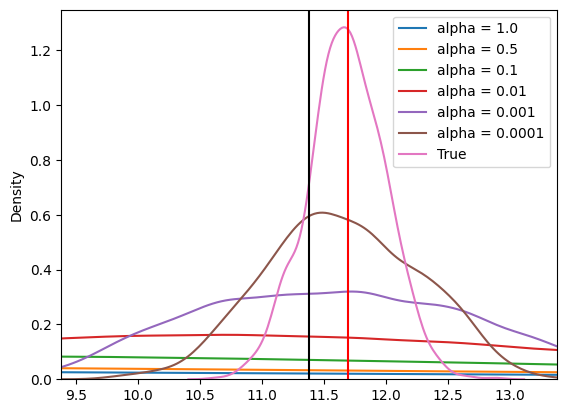

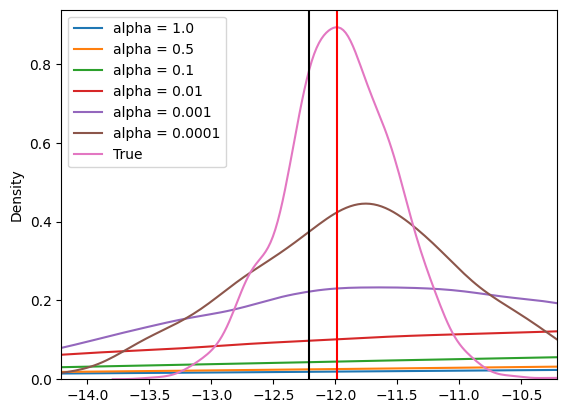

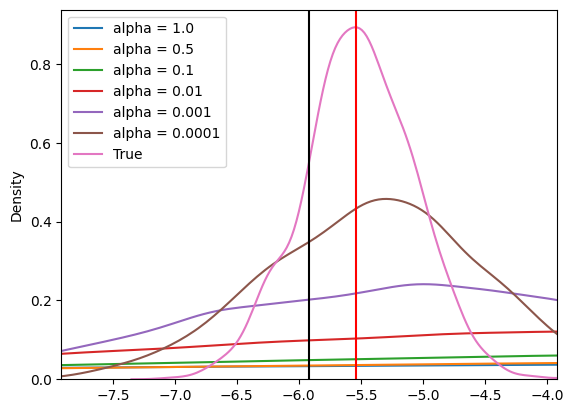

In [15]:
for k in range(K):
    
    indexes = jnp.argsort(dists)
    for alpha in [1., .5,.1, .01,.001,.0001]:
        sns.kdeplot(betas[indexes[:int(alpha*N_abc)], k], label = f"alpha = {alpha}")
    true_marg = true_posterior_marginal_k_jax(X_DESIGN, TRUE_DATA, MU0, SIGMA0, SIGMA, k, int(alpha*N_abc))
    sns.kdeplot(true_marg, label = "True")
    plt.axvline(TRUE_BETAS[k], color = "black")
    plt.axvline(beta_ols[k], color = "red")
    plt.legend()
    plt.xlim(TRUE_BETAS[k]-2, TRUE_BETAS[k]+2)
    plt.show()


In [18]:
from scipy.stats import ranksums

In [34]:
a = stats.norm.rvs(loc = 0, scale = 1, size = 1000)
b = stats.norm.rvs(loc = 0, scale = 1, size = 1000)
c = stats.norm.rvs(loc = 0, scale = 10, size = 1000)
print(ranksums(a,b), ranksums(a,c), ranksums(b,c), sep = "\n")

RanksumsResult(statistic=-1.024999933447908, pvalue=0.3053632190685214)
RanksumsResult(statistic=-1.0768849406562866, pvalue=0.2815316716532309)
RanksumsResult(statistic=-0.9304453158338332, pvalue=0.3521405650224644)


shapes: (10000, 3) (10000, 3)
For alpha = 1.0 epsilon = inf on a :
RanksumsResult(statistic=-92.25935851645426, pvalue=0.0)


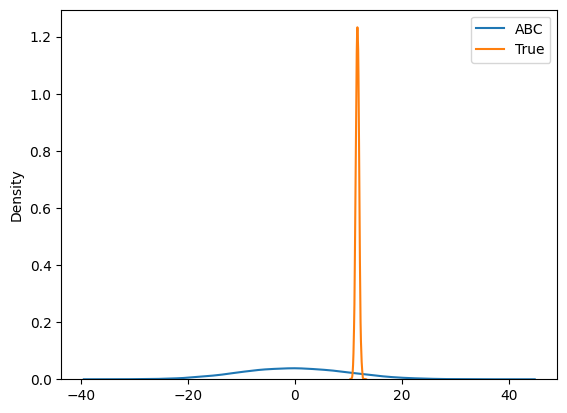

shapes: (10000, 3) (10000, 3)
For alpha = 0.5 epsilon = 4216.15771484375 on a :
RanksumsResult(statistic=-76.52588069693066, pvalue=0.0)


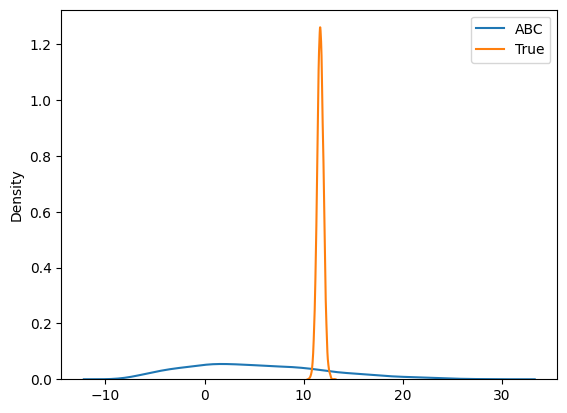

shapes: (10000, 3) (10000, 3)
For alpha = 0.1 epsilon = 1143.8299560546875 on a :
RanksumsResult(statistic=-47.73034649609878, pvalue=0.0)


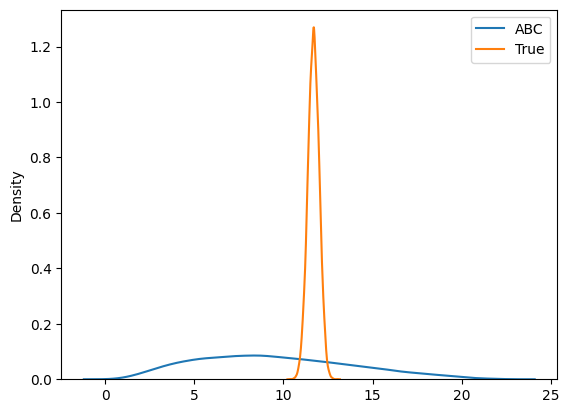

shapes: (10000, 3) (10000, 3)
For alpha = 0.01 epsilon = 254.97702026367188 on a :
RanksumsResult(statistic=-23.126046561024495, pvalue=2.53302480145242e-118)


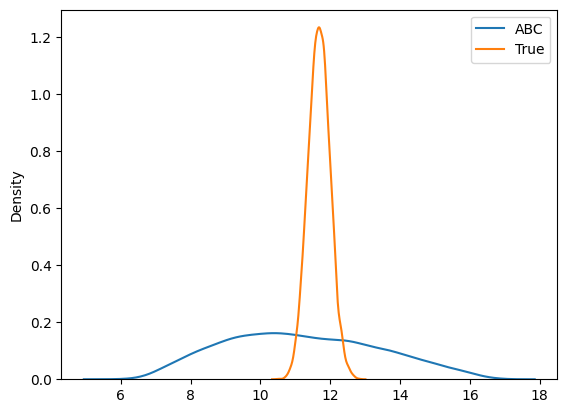

shapes: (10000, 3) (10000, 3)
For alpha = 0.001 epsilon = 63.95749282836914 on a :
RanksumsResult(statistic=-8.37479447200011, pvalue=5.5320330576901777e-17)


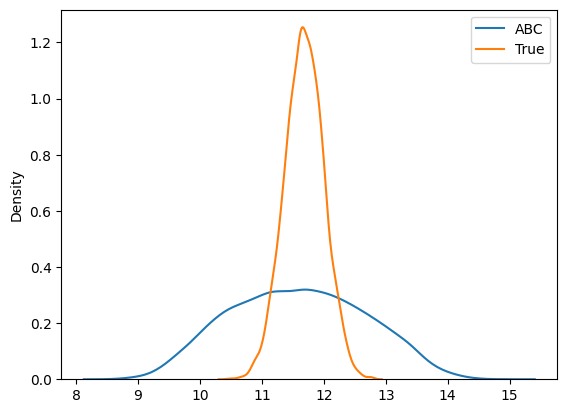

In [48]:
N_SAMPLE = 10000
pvals = []
statss = []
for alpha in [1., .5,.1, .01,.001]:
    epsilon = float( dists[indexes][int(alpha*N_abc)])
    if alpha == 1.:
        epsilon = np.inf
    key, key_true, key_abc = random.split(key, 3)
    
    _, betas_abc, _, _ = ABC_epsilon(key_abc, N_SAMPLE, prior_simulator, data_simulator, discrepancy, epsilon, TRUE_DATA)
    betas_true = true_posterior_jax(key_true,X_DESIGN, TRUE_DATA, MU0, SIGMA0, SIGMA, N_SAMPLE)
    print('shapes:', betas_abc.shape, betas_true.shape)
    print("For alpha = {} epsilon = {} on a :".format(alpha, epsilon))
    pvals.append(ranksums(betas_abc[:,0], betas_true[:,0]).pvalue)
    statss.append(ranksums(betas_abc[:,0], betas_true[:,0]).statistic)
    print(ranksums(betas_abc[:,0], betas_true[:,0]))
    sns.kdeplot(betas_abc[:,0], label = "ABC")
    sns.kdeplot(betas_true[:,0], label = "True")
    plt.legend()
    plt.show()


In [49]:
statss

[-92.25935851645426,
 -76.52588069693066,
 -47.73034649609878,
 -23.126046561024495,
 -8.37479447200011]

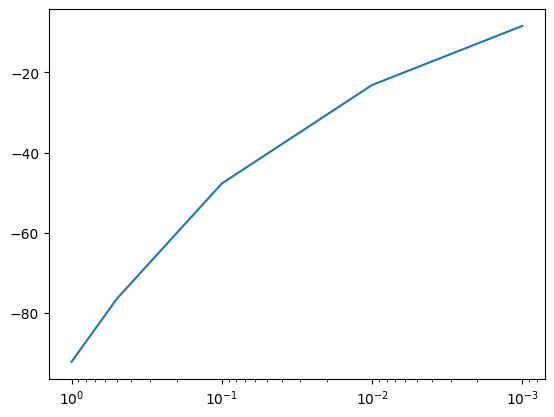

In [52]:
ALPHAS = [1., .5,.1, .01,.001]
plt.plot(ALPHAS, statss)
plt.gca().invert_xaxis()
plt.xscale("log")
plt.show()


In [35]:
key, key1, key2 = random.split(key, 3)
true_post1 = true_posterior_jax(key1, X_DESIGN, TRUE_DATA, MU0, SIGMA0, SIGMA, 1000)
true_post2 = true_posterior_jax(key2, X_DESIGN, TRUE_DATA, MU0, SIGMA0, SIGMA, 1000)

ranksums(true_post1[:,0], true_post2[:,0])

RanksumsResult(statistic=-0.5226833673924641, pvalue=0.6011946146782734)

In [36]:
true_post = true_posterior_jax(key,X_DESIGN, TRUE_DATA, MU0, SIGMA0, SIGMA, 1000)

In [ ]:
with pm.Model() as model:
    # Convert X_DESIGN to a tensor variable
    X_DESIGN_shared = np.array(X_DESIGN)
    # Priors for unknown model parameters
    betas = pm.Normal('betas', mu=MU0, sigma=SIGMA0, shape=K)
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=pytensor.tensor.dot(X_DESIGN_shared, betas), sigma=SIGMA, observed=TRUE_DATA)
    # Sample from the posterior
    trace = pm.sample(10000, tune=1000)
beta_post = np.array(trace.posterior.betas).reshape(-1, K)

AssertionError: 

In [ ]:


key = random.PRNGKey(0)
import sys
if len(sys.argv)>1: 
    K = int(sys.argv[1])
    print("K:", K)
else: 
    K = 10
    
PATH_RESULTS = os.getcwd() + "/examples/Linear-Reg/plots_for_paper/local/K_{}/".format(int(K))
PATH_FIGURES = PATH_RESULTS + "figures/"
PATH_PICKLES = PATH_RESULTS + "pickles/"
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)
if not os.path.exists(PATH_FIGURES):
    os.makedirs(PATH_FIGURES)
if not os.path.exists(PATH_PICKLES):
    os.makedirs(PATH_PICKLES)
    

N_KDE = 1000
N_POINTS_TRAIN = 10000
N_POINTS_TEST = 10000
N_SAMPLE = 100
N_SAMPLES = 1
N_EPSILON = 1000
N_DATASETS = 2
N_EPOCHS = 1   


MU0 = 0.
SIGMA0 = 10.
SIGMA = 1.
N_DATA = 500
PRIOR_ARGS = [MU0, SIGMA0]

PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
MINN, MAXX = norm.ppf(1e-5, loc = MU0, scale = SIGMA0), norm.ppf(1-1e-5, loc = MU0, scale = SIGMA0)
prior = stats.norm(loc = MU0, scale = SIGMA0)


key = random.PRNGKey(0)
key, key_beta = random.split(key)
TRUE_BETAS  = (random.normal(key_beta, (K,))*SIGMA0 + MU0)
TRUE_BETAS = TRUE_BETAS[jnp.argsort(jnp.abs(TRUE_BETAS))[::-1]]
       
key, key_design = random.split(key)
X_DESIGN = x_design_simulator(key_design, N_DATA, K)
    
MODEL_ARGS = [SIGMA, X_DESIGN]
key, key_data = random.split(key)
TRUE_DATA = random.normal(key_data, (N_DATA,))*SIGMA + jnp.dot(X_DESIGN, TRUE_BETAS)

        
        
trace_path = PATH_RESULTS + "data.pkl"

if not os.path.exists(trace_path):
    with pm.Model() as model:
        # Convert X_DESIGN to a tensor variable
        X_DESIGN_shared = np.array(X_DESIGN)
        # Priors for unknown model parameters
        betas = pm.Normal('betas', mu=MU0, sigma=SIGMA0, shape=K)
        # Likelihood (sampling distribution) of observations
        y_obs = pm.Normal('y_obs', mu=pytensor.tensor.dot(X_DESIGN_shared, betas), sigma=SIGMA, observed=TRUE_DATA)
        # Sample from the posterior
        trace = pm.sample(N_KDE, tune=1000)
    beta_post = np.array(trace.posterior.betas).reshape(-1, K)

    dico = {"X_DESIGN":X_DESIGN, "TRUE_DATA":TRUE_DATA, "TRUE_BETAS":TRUE_BETAS, "true_post":beta_post}
    with open(trace_path, "wb") as f:
        pickle.dump(dico, f)
else:
    with open(trace_path, "rb") as f:
        dico = pickle.load(f)




LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = .5
RTOL = 1e-4  
ACCUMULATION_SIZE = 200
LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256
NUM_BATCH = 1024
NUM_CLASSES = 2
HIDDEN_SIZE = 256
NUM_LAYERS = 2
WDECAY = .001
N_GRID_FINAL = 10000
N_GRID_EXPLO = 1000


EPSILONS = {}
C2ST_ABC = {}
C2ST_NN = {}
C2ST_KDE_NN = {}
C2ST_KDE_NN_EMPIRIC = {}
PARAMS = {}
TEST_ACCURACY = {}

key = random.PRNGKey(0)
TRUE_BETAS = dico["TRUE_BETAS"]
X_DESIGN = dico["X_DESIGN"]
TRUE_DATA = dico["TRUE_DATA"]
beta_post = dico["true_post"]
MODEL_ARGS = [SIGMA, X_DESIGN]


N_EPSILON = 1000000
zs, mus, dists, key = ABC_epsilon(key, N_EPSILON, prior_simulator, data_simulator, discrepancy, np.inf, TRUE_DATA)
ALPHAS = [.99,.9, .75,.5,.25, .1,.05, .01, .005, .001, .0005,.0001]
EPSILONS = {1.: jnp.inf}
for alpha in ALPHAS: 
    EPSILONS[alpha] = jnp.quantile(dists, alpha)

ALPHAS = [1.]+ALPHAS





if K > 2:
    INDEX_BETAS = [0, K-1, K//2]
else: 
    INDEX_BETAS = [0, K-1]
    for INDEX_BETA in INDEX_BETAS:
        data_simulator = jit(lambda key, beta: data_simulator_raw(key, beta, X_DESIGN, INDEX_BETA)) 
        TRUE_BETA = TRUE_BETAS[INDEX_BETA]
        if INDEX_BETA == 0:
            beta_mode = "max"
            PATH_BETA = PATH_RESULTS + "beta_max/"
        elif INDEX_BETA == K-1:
            beta_mode = "min"
            PATH_BETA = PATH_RESULTS + "beta_min/"
        else:
            beta_mode = "random"
            PATH_BETA = PATH_RESULTS + "beta_random/"
        if not os.path.exists(PATH_BETA):
                os.makedirs(PATH_BETA)
    
        EPSILONS_i = {}
        PARAMS_i = {}
        TEST_ACCURACY_i = {}
        C2ST_ABC_i = {}
        C2ST_NN_i = {}
        C2ST_KDE_NN_EMPIRIC_i = {}
        
    for alpha in (ALPHAS):
        if alpha == 1.:  EPSILONS_i[alpha] = jnp.inf
        else: EPSILONS_i[alpha] = jnp.quantile(dists, alpha)
        
        EPSILON_STAR = EPSILONS_i[alpha]
        print(f"----------------------\nBETA = {beta_mode} ALPHA = {alpha} EPSILON = {EPSILON_STAR:.2}\n----------------------")


        print("Simulations of the testing dataset...")
        time_sim = time.time()
        key, subkey = random.split(key)
        X_test, y_test, key = get_dataset(subkey, N_POINTS_TEST, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
        print("Test check:", np.any(X_test[:,0]!=np.sort(X_test[:,0])))
        print('Time to simulate the testing dataset: {:.2f}s\n'.format(time.time()-time_sim))


        print("Simulations of the training dataset...")
        time_sim = time.time()
        key, subkey = random.split(key)
        X_train, y_train, key = get_dataset(subkey, N_POINTS_TRAIN, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
        print("Train check:", np.any(X_train[:,0]!=np.sort(X_train[:,0])))
        print('Time to simulate the training dataset: {:.2f}s\n'.format(time.time()-time_sim))
        
        print("Training the neural network...")
        time_nn = time.time()
        params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(key, N_EPOCHS, NUM_LAYERS, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE, NUM_BATCH, LEARNING_RATE, WDECAY, PATIENCE, COOLDOWN, FACTOR, RTOL, ACCUMULATION_SIZE, LEARNING_RATE_MIN, prior_simulator, data_simulator, discrepancy, true_data = TRUE_DATA, X_train = X_train, y_train = y_train, X_test = X_test, y_test =  y_test, N_POINTS_TRAIN = N_POINTS_TRAIN, N_POINTS_TEST = N_POINTS_TEST, epsilon = EPSILON_STAR, verbose = True)
        print('Time to train the neural network: {:.2f}s\n'.format(time.time()-time_nn))

        PARAMS_i[alpha] = params
        TEST_ACCURACY_i[alpha] = test_accuracy[-1]
        
        
        X = np.concatenate([X_train, X_test], axis=0)
        key, subkey = random.split(key)
        kde_approx_empiric = gaussian_kde(X[random.choice(subkey, X.shape[0], (N_KDE,)),0])

        print("Find grid KDE NN empiric approx...", end ="")
        time_grid = time.time()
        grid_kde_nn_empiric, pdf_kde_nn_empiric = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA, kde_approx_empiric), 10000, 10000, MINN, MAXX)
        print("Done in {:.2} sec.".format(time.time()-time_grid))
        print("Find grid NN approx...", end = "")
        time_grid= time.time()
        grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 10000, 10000, MINN, MAXX)
        print("Done in {:.2} sec.".format(time.time()-time_grid))
        accuraccy_abc, accuraccy_nn, accuraccy_kde_nn, accuraccy_kde_nn_empiric = [], [], [], []
        print("Sampling {} times...".format(N_SAMPLES), end ="")
        time_sample = time.time()
        sample_true = dico["true_post"][:,INDEX_BETA]
        for _ in range(N_SAMPLES):
        
            key, key_abc, key_nn, key_kde_nn = random.split(key, 4)
            sample_nn = post_sample(key_nn, grid_nn, pdf_nn, N_SAMPLE)
            sample_abc = X[random.choice(key_abc, X.shape[0], (N_SAMPLE,)),0]
            sample_kde_nn_empiric = post_sample(key_kde_nn, grid_kde_nn_empiric, pdf_kde_nn_empiric, N_SAMPLE)
            if np.isnan(sample_nn).any(): accuraccy_nn.append(1)
            else: accuraccy_nn.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_nn)[:,None]))[0])
            if np.isnan(sample_abc).any(): accuraccy_abc.append(1)
            else: accuraccy_abc.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_abc)[:,None]))[0])
            if np.isnan(sample_kde_nn_empiric).any(): accuraccy_kde_nn_empiric.append(1)
            else: accuraccy_kde_nn_empiric.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_kde_nn_empiric)[:,None]))[0])
        print("Done in {:.2} sec.".format(time.time()-time_sample)) 
        C2ST_ABC_i[alpha] = np.array(accuraccy_abc)
        C2ST_NN_i[alpha] = np.array(accuraccy_nn)
        C2ST_KDE_NN_EMPIRIC_i[alpha] = np.array(accuraccy_kde_nn_empiric)

        print("\n---------------------------------------nITERATION BETA = {} ALPHA = {} DONE IN {:.2} SECONDS!\n---------------------------------------".format(beta_mode+1,alpha, time.time()-time_sim))
    
    C2ST_ABC[beta_mode] = C2ST_ABC_i
    C2ST_NN[beta_mode] = C2ST_NN_i
    C2ST_KDE_NN[beta_mode] = C2ST_KDE_NN_i
    C2ST_KDE_NN_EMPIRIC[beta_mode] = C2ST_KDE_NN_EMPIRIC_i
    PARAMS[beta_mode] = PARAMS_i
    TEST_ACCURACY[beta_mode] = TEST_ACCURACY_i
    EPSILONS[beta_mode] = EPSILONS_i
    
    mean_abc = np.array([C2ST_ABC_i[alpha].mean() for alpha in ALPHAS])
    std_abc = np.array([C2ST_ABC_i[alpha].std() for alpha in ALPHAS])
    conf_interval_abc = 1.96*std_abc/np.sqrt(N_SAMPLES)

    mean_nn = np.array([C2ST_NN_i[alpha].mean() for alpha in ALPHAS])
    std_nn = np.array([C2ST_NN_i[alpha].std() for alpha in ALPHAS])
    conf_interval_nn = 1.96*std_nn/np.sqrt(N_SAMPLES)

    mean_kde_nn = np.array([C2ST_KDE_NN_i[alpha].mean() for alpha in ALPHAS])
    std_kde_nn = np.array([C2ST_KDE_NN_i[alpha].std() for alpha in ALPHAS])
    conf_interval_kde_nn = 1.96*std_kde_nn/np.sqrt(N_SAMPLES)

    mean_kde_nn_empiric = np.array([C2ST_KDE_NN_EMPIRIC_i[alpha].mean() for alpha in ALPHAS])
    std_kde_nn_empiric = np.array([C2ST_KDE_NN_EMPIRIC_i[alpha].std() for alpha in ALPHAS])
    conf_interval_kde_nn_empiric = 1.96*std_kde_nn_empiric/np.sqrt(N_SAMPLES)

    f, ax = plt.subplots(1, 1, figsize = (10, 5))
    plt.errorbar(ALPHAS, mean_abc, yerr = conf_interval_abc, label = "ABC", color = "orange", fmt='o-', capsize=5)
    plt.errorbar(ALPHAS, mean_nn, yerr = conf_interval_nn, label = "ABC-NRE without correction", color = "red", fmt='o-', capsize=5)
    plt.errorbar(ALPHAS, mean_kde_nn, yerr = conf_interval_kde_nn, label = "ABC-NRE with correction", color = "blue", fmt='o-', capsize=5)
    plt.errorbar(ALPHAS, mean_kde_nn_empiric, yerr = conf_interval_kde_nn_empiric, label = "ABC-NRE with correction empiric", color = "purple", fmt='o-', capsize=5)

    plt.title("Methods comparison for $\mu =$ {:.2} $\sigma_0 =$ {}".format(TRUE_MU, int(SIGMA0)))
    plt.xlabel("$\epsilon$")
    plt.gca().invert_xaxis()
    plt.xscale("log")
    plt.ylabel("C2ST accuracy")
    plt.axhline(.5, color = "grey", linestyle = "--")
    plt.legend(loc = "upper center")
    name_fig_i = PATH_FIGURES + "{}_method_comparison_single_mu_{:.3}_sigma0_{}.png".format(i_dataset+1,TRUE_MU,int(SIGMA0))
    plt.savefig(name_fig_i)
    plt.show()

    print("Figure saved in :", name_fig_i)
    
    dico_i = {"ALPHAS":ALPHAS, "C2ST_ABC":C2ST_ABC_i, "C2ST_NN":C2ST_NN_i, "C2ST_KDE_NN":C2ST_KDE_NN_i, "C2ST_KDE_NN_EMPIRIC":C2ST_KDE_NN_EMPIRIC_i, "PARAMS":PARAMS_i, "TEST_ACCURACY":TEST_ACCURACY_i, "EPSILONS":EPSILONS_i, "TRUE_MU":TRUE_MU, "TRUE_DATA":TRUE_DATA, "SIGMA0":SIGMA0, "MU0":MU0, "SIGMA":SIGMA, "N_DATA":N_DATA, "MODEL_ARGS":MODEL_ARGS, "PRIOR_ARGS":PRIOR_ARGS, "N_POINTS_TRAIN":N_POINTS_TRAIN, "N_POINTS_TEST":N_POINTS_TEST, "N_EPOCHS":N_EPOCHS, "LEARNING_RATE":LEARNING_RATE, "PATIENCE":PATIENCE, "COOLDOWN":COOLDOWN, "FACTOR":FACTOR, "RTOL":RTOL, "ACCUMULATION_SIZE":ACCUMULATION_SIZE, "LEARNING_RATE_MIN":LEARNING_RATE_MIN, "BATCH_SIZE":BATCH_SIZE, "NUM_BATCH":NUM_BATCH, "NUM_CLASSES":NUM_CLASSES, "HIDDEN_SIZE":HIDDEN_SIZE, "NUM_LAYERS":NUM_LAYERS, "WDECAY":WDECAY, "N_GRID_FINAL":N_GRID_FINAL, "N_GRID_EXPLO":N_GRID_EXPLO, "N_KDE":N_KDE, "N_SAMPLE":N_SAMPLE, "N_SAMPLES":N_SAMPLES}
    n_file_i = "examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma/pickles/dataset_{}_method_comparison_single_mu_{:.2}_sigma0_{}.xy".format(i_dataset+1, TRUE_MU,int(SIGMA0))
    
    name_file_i = PATH_PICKLES + "{}_method_comparison_single_mu_{:.2}_sigma0_{}.xy".format(i_dataset+1, TRUE_MU,int(SIGMA0))
    with lzma.open(name_file_i, "wb") as f:
        pickle.dump(dico_i, f)
    print("Data saved in ", name_file_i)
    
    print("\n\n\n\n---------------------------------------\nITERATION DATASET = {} DONE IN {:.2} SECONDS!\n---------------------------------------\n\n\n\n".format(i_dataset+1, time.time()-time_data_set))
    

C2ST_ABC_array = np.array([[C2ST_ABC[i_dataset][alpha][j] for i_dataset in range(N_DATASETS) for j in range(N_SAMPLES)] for alpha in ALPHAS])
C2ST_NN_array = np.array([[C2ST_NN[i_dataset][alpha][j] for i_dataset in range(N_DATASETS) for j in range(N_SAMPLES)] for alpha in ALPHAS])
C2ST_KDE_NN_array = np.array([[C2ST_KDE_NN[i_dataset][alpha][j] for i_dataset in range(N_DATASETS) for j in range(N_SAMPLES)] for alpha in ALPHAS])
C2ST_KDE_NN_EMPIRIC_array = np.array([[C2ST_KDE_NN_EMPIRIC[i_dataset][alpha][j] for i_dataset in range(N_DATASETS) for j in range(N_SAMPLES)] for alpha in ALPHAS])

mean_abc = np.array([C2ST_ABC_array[i].mean() for i in range(C2ST_ABC_array.shape[0])])
std_abc = np.array([C2ST_ABC_array[i].std() for i in range(C2ST_ABC_array.shape[0])])
conf_interval_abc = 1.96*std_abc/np.sqrt(N_SAMPLES)

mean_nn = np.array([C2ST_NN_array[i].mean() for i in range(C2ST_NN_array.shape[0])])
std_nn = np.array([C2ST_NN_array[i].std() for i in range(C2ST_NN_array.shape[0])])
conf_interval_nn = 1.96*std_nn/np.sqrt(N_SAMPLES)


f, ax = plt.subplots(1, 1, figsize = (10, 5))
plt.errorbar(ALPHAS, mean_abc, yerr = conf_interval_abc, label = "ABC", color = "orange", fmt='o-', capsize=5, alpha = .5)
plt.errorbar(ALPHAS, mean_nn, yerr = conf_interval_nn, label = "ABC-NRE without correction", color = "red", fmt='o-', capsize=5, alpha = .5)
plt.errorbar(ALPHAS, mean_kde_nn, yerr = conf_interval_kde_nn, label = "ABC-NRE with correction", color = "blue", fmt='o-', capsize=5, alpha = .5)
plt.errorbar(ALPHAS, mean_kde_nn_empiric, yerr = conf_interval_kde_nn_empiric, label = "ABC-NRE with correction empiric", color = "purple", fmt='o-', capsize=5, alpha = .5)

plt.title("Methods comparison for $\sigma_0 =$ {}".format(int(SIGMA0)))
plt.xlabel("$\epsilon$")
plt.gca().invert_xaxis()
plt.xscale("log")
plt.ylabel("C2ST accuracy")
plt.axhline(.5, color = "grey", linestyle = "--")
plt.legend(loc = "upper center")
name_fig = PATH_FIGURES + "method_comparison_sigma0_{}.png".format(int(SIGMA0))
name_file = PATH_PICKLES + "method_comparison_sigma0_{}.xy".format(int(SIGMA0))

plt.savefig(name_fig)
plt.show()

print("Figure saved in :", name_fig)


dico = {"EPSILONS": EPSILONS, "PARAMS": PARAMS, "TEST_ACCURACY": TEST_ACCURACY, "C2ST_ABC": C2ST_ABC, "C2ST_NN": C2ST_NN, "C2ST_KDE_NN": C2ST_KDE_NN, "C2ST_KDE_NN_EMPIRIC": C2ST_KDE_NN_EMPIRIC, "ALPHAS": ALPHAS, "TRUE_MUS": TRUE_MUS, "TRUE_DATAS": TRUE_DATAS, "SIGMA0": SIGMA0, "MU0": MU0, "SIGMA": SIGMA, "N_DATA": N_DATA, "MODEL_ARGS": MODEL_ARGS, "PRIOR_ARGS": PRIOR_ARGS, "N_POINTS_TRAIN": N_POINTS_TRAIN, "N_POINTS_TEST": N_POINTS_TEST, "N_EPOCHS": N_EPOCHS, "LEARNING_RATE": LEARNING_RATE, "PATIENCE": PATIENCE, "COOLDOWN": COOLDOWN, "FACTOR": FACTOR, "RTOL": RTOL, "ACCUMULATION_SIZE": ACCUMULATION_SIZE, "LEARNING_RATE_MIN": LEARNING_RATE_MIN, "BATCH_SIZE": BATCH_SIZE, "NUM_BATCH": NUM_BATCH, "NUM_CLASSES": NUM_CLASSES, "HIDDEN_SIZE": HIDDEN_SIZE, "NUM_LAYERS": NUM_LAYERS, "WDECAY": WDECAY, "N_GRID_FINAL": N_GRID_FINAL, "N_GRID_EXPLO": N_GRID_EXPLO, "N_KDE": N_KDE, "N_SAMPLE": N_SAMPLE, "N_SAMPLES": N_SAMPLES}

with lzma.open(name_file, "wb") as f:
    pickle.dump(dico, f)
print("Data saved in ", name_file)

print("\n\n\n\n---------------------------------------\nITERATION DONE IN {:.2} SECONDS!\n---------------------------------------\n\n\n\n".format(time.time()-time_begin))

